# Wrangling OpenStreetMap data

OpenStreetMap is an Open Source alternative to proprietary "Maps" software, like Google Maps and Apple Maps.

To someone not familiar with the Open Source world it may look like we are attempting to reinvent the wheel, and while sometimes it is just that, over time many projects are able to overcome their competition.

Some examples of that are Linux, it started small, and eventually overcame UNIX as the standard server operating system, and Python that has grown from a simple programming language to the awesome multipurpose one with many libraries that we have today.

The reason for this is that everyone may use it, study the source code, and contribute to it if they feel like it, and many companies saw the power behind a hive minded community, everyone doing their part, and harnessed it offering support for enterprise use, or some sort of standardization, while improving the code for everyone else, it's a win-win situation.

In the case of OpenStreetMap, anyone may contribute to its database by mapping their own part of the world. It's amazing to think that with a little help from many people we could map the entire world for free.

But, with human generated data, some problems arise, manual input tends to generate not only errors, but inconsistencies too.

The purpose to this project is to audit and improve the data of my current hometown, Curitiba, capital of the state of Paraná, in Brazil.

## Map Area

#### Curitiba, PR, Brazil

* https://www.openstreetmap.org/relation/297514
* https://en.wikipedia.org/wiki/Curitiba

The data was obtained using Mapzen's (https://mapzen.com/) custom extraction, and can be downloaded here (OSM XML):

* https://s3.amazonaws.com/mapzen.odes/ex_eAGW5zLXGHx6F61DQCWq5DyWKMwop.osm.bz2

## Data problems

When first wrangling this dataset, a few problems became evident:

* Over abbreviated or wrong street names
* Wrong or missing postal codes

So, let's fix them!

### First, let's load our dirty data into a SQLite database

The reason for this, is that we can easily do some queries into the data to find the best ways to fix it.

We'll need 2 modules I created:

The first is the OSM XML parser (called, well, osmparser), what it does is read a OSM XLM file and fragments it into 5 CSVs so that they can easily be imported to a SQL database, while validating it to the schema we will be using in the database:
  * "nodes.csv"
  * "nodes_tags.csv"
  * "ways.csv"
  * "ways_nodes.csv"
  * "ways_tags.csv"

  This module has the ability to change bad data if needed on the fly too, but we won't be using this function yet!


The second module is the SQLite database creator, called sqlcreator (see a pattern here?), which will finally turn the CSVs into a nice database.

In [25]:
import osmparser
import sqlcreator

osmparser.execute('curitiba.osm')
sqlcreator.execute('curitiba_dirty.db')

To communicate with the databases we'll be creating, I created a small module to run our commands, called sqloperations.

In [26]:
import sqloperations as sql

### Street names

Let's take a look at the street names in our data.

We'll be using a module I created called audit_streetnames to do it. This module not only selects the names from the data, it analyzes them and suggests better ones. If there's any strange names that weren't automatically fixed, they are highlighted by an \*, and we can manually fix them by giving it a dictionary of overrides.

Calling its main function prints all the problems with the street name data and returns a dictionary of fixes that we will use to fix the data afterwards!

Let's take a look into the acceptable street names first:

* Rua
* Avenida
* Travessa
* Praça
* Rodovia
* Alameda
* Estrada
* Linha
* Largo
* Marginal

Street names in Brazil always starts with the type: Rua means Street, Avenida means Avenue, and so on.

Do we have problems with the data?

In [27]:
import audit_streetnames
fixedStreetNames = audit_streetnames.execute('curitiba.osm', False, False)

Using this module, we have a few automatic fixes, but a few we'll need to look closer into. They are:
* Filipinas => Filipinas
* Rui Barbosa => Rui Barbosa
* Centro Politécnico da UFPR, Caixa Postal 19100 => Centro Politécnico da UFPR, Caixa Postal 19100
* BR-116 => BR-116
* Vicente za => Vicente za
* domingos benatto => domingos benatto
* Residencial Simão Brante => Residencial Simão Brante
* Comendador Franco => Comendador Franco

We have 2 that were fixed, but are still not perfect:
* rua Samanbaia -179- São Francisco -Araucária => Rua Samanbaia -179- São Francisco -Araucária
* RUA VICENTE DE CARVALHO => Rua VICENTE DE CARVALHO


#### End result

Further cleaning was made, but because of length contraints fo this report, they where omitted.

To check the full cleaning process, please refer to the full project: **Project.ipynb**

Because of this, lets import the full **streetOverrides** dictionary and the **specialStreetOverrides** and create a new **fixedStreetNames** using the overrides:

In [36]:
import overrides
streetOverrides = overrides.streetOverrides
specialStreetOverrides = overrides.specialStreetOverrides

In [37]:
fixedStreetNames = audit_streetnames.execute('curitiba.osm', False, False, 
                                             overrides=streetOverrides, 
                                             specialOverrides=specialStreetOverrides)

### Postal Codes

Brazilian postal codes are supposed to follow this format: 00000-000, so we're going to update them to follow the standard.

Ideally our data would be only Curitiba, but the way MapZen extraction works we got a dataset that comprises the metropolitan region of Curitiba, so the valid postal codes are between 80000-001 and 83800-999, instead of 80000-000 and 82999-999 for just Curitiba.

This information was found using this article: https://thiagorodrigo.com.br/artigo/cep-brasil-lista-de-cep-por-estados-capitais-e-interior/

Another supposed problem I found when looking at the data is that postal code data is divided into 2 different types of tags (below key, value, type):

* 'postcode', '00000-000', 'addr'
* 'postal_code', '00000-000', 'regular'

But a quick search into the OpenStreetMap wiki (http://wiki.openstreetmap.org/wiki/Key:postal_code) showed me that both ways are valid, so we'll keep the current keys and types and just fix the values where needed.

The most common mistakes are:
* Not using the dash
* Using a dot after the first 2 digits

This was expected, because many forms use a dot after the first 2 digits to make the postal code more readable, and omitting the dash is a common practice too.

Using a function called **audit_postcodes** we can correct the 2 common mistakes above and check to see if the postal code is within the acceptable range.

To see the fixes, please refer to the full project: Project.ipynb

In [30]:
import audit_postcodes
fixedPostcodes = audit_postcodes.execute('curitiba.osm', False, False)

Using the module, almost all the values were fixed automatically, but we still have a few problematic data points:

* 87483-001
* 87499-002
* 87583-003
* 87583-002
* 85583-004
* 43508-430
* 3288-2129
* 08476995954

While trying to fix these issues, I found no easy way to do so.

I see no point to keep the invalid data and import it into our database, so I programmed the **osmparser** to simply drop the tags that have incorrect information: value == 'Invalid Postal Code'.

But check the **Additional Ideas** section by the end of the project for a way to make the postal code data complete!

### Creating the Final Database
To create our cleaned database, we'll call our **osmparser** again, but this time, we'll pass the **fixedStreetNames**, **specialStreetOverrides** and **fixedPostcodes** as arguments.

And then we'll create another database with the clean data calling the **sqlcreator** module with the name of our final database (curitiba.db):

In [31]:
osmparser.execute('curitiba.osm', fixedStreetNames=fixedStreetNames,
                  specialStreetOverrides=specialStreetOverrides,
                  fixedPostcodes=fixedPostcodes)
sqlcreator.execute('curitiba.db')

As every problem we previouslly had is nowhere to be found, and with our newly created database, we're ready to do some queries!

## Exploring the Data

### File Sizes:
    curitiba.osm-------- 65.98 MB
    curitiba_dirty.db--- 36.81 MB
    curitiba.db--------- 36.81 MB
    nodes.csv----------- 23.84 MB
    nodes_tags.csv------  1.14 MB
    ways.csv------------  3.14 MB
    ways_nodes.csv------  8.84 MB
    ways_tags.csv-------  4.66 MB

### Number of Nodes and Ways
    SELECT COUNT(*) FROM nodes;
    SELECT COUNT(*) FROM ways;

    Nodes: 280077

### Number of unique users
    SELECT COUNT(DISTINCT(e.uid))          
    FROM (SELECT uid FROM nodes UNION ALL SELECT uid FROM ways) e;

    541

### Top 10 users by contribution number
    SELECT e.user, COUNT(*) as num
    FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) e
    GROUP BY e.user
    ORDER BY num DESC
    LIMIT 10;

    dclarks------------- 79506
    jump6024------------ 54571
    luisgustavo1968----- 43808
    Daniel Lauer-------- 22027
    patodiez------------ 13453
    fsbrace------------- 10317
    O Bicho Geográfico--  9925
    caio----------------  8078
    Larissa Lo----------  6688
    elias lopes---------  5541

### Plotting a map using Way Nodes

The first thing I thought when wrangling with this data was that maybe I could use the coordinates from way nodes to plot a map that could provide an overview of the completeness of the dataset. Here's the result

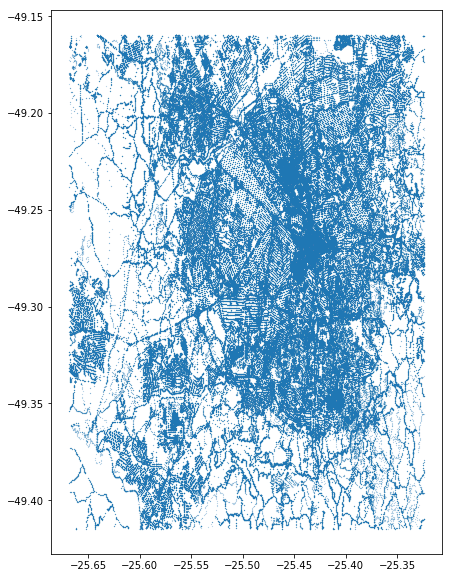

In [32]:
%matplotlib inline
import plot_map
plot_map.execute()

From this plot we can see that our dataset contains much more information than just Curitiba, we have most of the metropolitan area too!

For comparison click here for a map of just Curitiba:

* https://www.openstreetmap.org/relation/297514

### Amenities
    SELECT value, COUNT(*) as num
    FROM nodes_tags
    WHERE key='amenity'
    GROUP BY value
    ORDER BY num DESC
    LIMIT 10;

    restaurant---------- 267
    school-------------- 267
    fuel---------------- 189
    pharmacy------------ 173
    bank---------------- 166
    fast_food----------- 123
    place_of_worship----  77
    clinic--------------  73
    pub-----------------  71
    parking-------------  44

Just 17 bars? This dataset is not complete by a large margin in my experience!

Not surprising restaurants (and schools) take the first spot, we, 'curitibanos', sure like to go out to eat!

* http://gastronomiadescomplicada.blogspot.com.br/2011/09/cenario-gastronomico-curitibano.html

From this article we get the information that the favorite cuisines of the 'curitibanos' are **pizza** and **steak_house** (called *churrascaria* in portuguese), do our data support this view?
    
    SELECT nodes_tags.value, COUNT(*) as num
    FROM nodes_tags 
    JOIN (SELECT DISTINCT(id) FROM nodes_tags WHERE value='restaurant') i
    ON nodes_tags.id=i.id
    WHERE nodes_tags.key='cuisine'
    GROUP BY nodes_tags.value
    ORDER BY num DESC
    LIMIT 5;

    pizza---------- 40
    regional------- 38
    steak_house---- 17
    italian-------- 15
    japanese------- 12
    
Yes, but with regional in the second place, during the weekdays we tend to eat reginal food, so not surprising too.

## Additional Ideas

### Fixing missing or wrong postal codes

Postal codes in Brazil changes between blocks, so using latitude and longitude information to get a correct code is difficult.

We can use the Google Maps API, documented here: 
* https://developers.google.com/maps/documentation/geocoding/intro?hl=en-us#ReverseGeocoding 

But wrangling the JSON data we receive from requests to find the correct postal code, based on latitude, longitude and house number is a project in its own, outside the scope of this one. So, here's a valid way that we could improve the data, and even make it so all the missing postal_code information is complete!

An example of using the API to try to fix one problematic postal code found during the data wrangling:

    SELECT lat, lon FROM NODES n JOIN Nodes_tags nt ON n.id = nt.id
    WHERE nt.key LIKE 'post%' AND nt.value = '87483-001'
    UNION
    SELECT lat, lon FROM NODES n JOIN ways_nodes wn ON n.id = wn.node_id
    JOIN ways_tags wt ON wn.id = wt.id
    WHERE wt.key LIKE 'post%' AND wt.value = '87483-001;

    (-25.5854049, -49.3364096),
    (-25.585306, -49.3368662),
    (-25.5852788, -49.336376),
    (-25.585152700000002, -49.3363424),
    (-25.585133600000002, -49.3368174),
    (-25.585133600000002, -49.336473299999994)
    
OBS: Using the dirty database, as this data didn't make into the final database due to invalid postal code

Using the first pair of coordinates to create a request:

* http://maps.google.com/maps/api/geocode/json?address=-25.5854049,-49.3364096



Looking at the data found using the link above we can see that the first suggested postal code for this pair of coordinates is **81490-544** which comprises the house number interval of **266 to 360**, but we have a lot more data than just that. 

In this case for example, our data point (house number: 160) is not within this house number range.

But that is expected, our coordinates (-25.5854049, -49.3364096) are just outside the bounds of this first suggestion:

* Latitude: -25.5852315 to -25.5854355
* Longitude: -49.336302 to -49.3364077

The correct suggestion is **81490-424**, the coordinates are:

* Latitude: -25.5820175 to -25.5861128
* Longitude: -49.3361306 to -49.3373991

So it's possible to implement a way to use the Google Maps API to programmatically fix the postal codes.

Using the name tag for this data point (CMEI Dona Bertha) we can confirm the postal code:

* http://www.educacao.curitiba.pr.gov.br/conteudo/localizacao-dona-bertha-centro-municipal-de-educacao-infantil-/2718

#### Problems:
The problem with this approach is that, while valid for the creation of this project and it's associated database, such information cannot be used to fix OpenStreetMap directly, as it's against the 'Google Maps/Google Earth APIs Terms of Service', particularly this section:
* 10.4.c.i: No creation of a substitute service. You will not use the Service to create a Maps API Implementation that is a substitute for, or substantially similar service to, Google Maps (at https://www.google.com/maps (or such other URL as Google may provide)) ("Google Maps") or the Service.

Also, there's a limit of request we can make to the API before our access is blocked for some time:
* 10.4.b: No use beyond transaction limits and usage policies. If your Maps API Implementation generates a high volume of transactions, Google reserves the right to set transaction limits, as described in the Maps APIs Documentation (https://developers.google.com/maps/faq?hl=en-us#usagelimits). Google also reserves the right to set other usage policies in the Documentation from time to time. If you want to engage in use outside these transaction limits or usage policies, you can purchase more usage capacity through the Maps API Standard pricing plan, or you can contact the Google Maps sales team for licensing options to address your needs. Google may decline your request, or condition acceptance on your agreement to additional terms and/or charges for that use.

More information can be found here:
* https://developers.google.com/maps/terms?hl=pt-br#10-license-restrictions

## Conclusion

After wrangling and cleaning the data I'm sure it's in a better state than before. It's obvious, too, that the dataset is incomplete (come on just 17 bars?).

The missing or wrong postal codes is an issue that may prevent this data from being used in a production enviroment, but analysing it as a community effort, it's pretty impressive what we already have.

SQL proved to be important when cleaning the data, as in many instances, without a database it'd be harder to find and correct the problems in the dataset.

If you're interested, please check **Project.ipynb** to see all the steps taked while creating this project!

## References

* Udacity's Data Analyst Nanodegree material and forums
* Wikipedia
* OpenStreetMap's wiki: https://wiki.openstreetmap.org/
* MapZen: https://mapzen.com/
* Google Maps
* http://www.ufpr.br/portalufpr/campi/
* https://thiagorodrigo.com.br/artigo/cep-brasil-lista-de-cep-por-estados-capitais-e-interior/
* http://gastronomiadescomplicada.blogspot.com.br/2011/09/cenario-gastronomico-curitibano.html
* Google Maps API documentation: https://developers.google.com/maps/documentation/geocoding/intro?hl=en-us
* http://www.educacao.curitiba.pr.gov.br/conteudo/localizacao-dona-bertha-centro-municipal-de-educacao-infantil-/2718
